In [2]:
import math

import matplotlib.pyplot as plt
import torch

from utils import seed, get_train_dataloader, get_test_dataloader, model_to_log, split_x_train, load_data_phase, read_phase_file
from model import get_model, load_model
from norm_denorm import calculate_mean_disp, norm, denorm

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

seed(2)

In [3]:
def train_epoch(model, loss, optimizer, dataloader, do_train):
    running_loss = 0.

    # Iterate over data.
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # forward and backward
        with torch.set_grad_enabled(do_train):
            preds = model(inputs)
            loss_value = loss(preds, targets)

            # backward + optimize only if in training phase
            if do_train:
                loss_value.backward()
                optimizer.step()

        # statistics
        running_loss += loss_value.item()

    epoch_loss = running_loss / len(dataloader)

    return epoch_loss


def train_model(model, loss, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs, config):
    best_val_loss = math.inf
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()  # Set model to evaluate mode

            epoch_loss = train_epoch(model, loss, optimizer, dataloader, phase == 'train')

            if phase == 'train':
                scheduler.step()

            if phase == 'val' and best_val_loss > epoch_loss:
                print('new best val loss', epoch_loss, 'epoch', epoch)
                best_val_loss = epoch_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'model_name': config['exp_name']
                }, f'{config["exp_name"]}.pth')

    return model

In [4]:
# hyperparameters
lr = 1e-3
epochs = 200
batch_size = 16
step_size = 20
gamma = 0.99
# parameters to be predicted
params = ['D']  # 'V', 'D', 'tp', 'tb'

train_folder = 'Data/DataField4'
mean_disp_file = 'mean_disp.json'

phase_size = (64, 64)

config = {
    "lr": lr,
    "epochs": epochs,
    "bs": batch_size,
    "sched": 'StepLR',
    "sched_ss": step_size,
    "sched_g": gamma,
    "params": '_'.join(params),
    "optim": 'Adam',
    "size": phase_size[0],
}
important_keys = ['optim', 'bs', 'params', "size"]
config['exp_name'] = '_'.join(map(lambda key: f'{key}={config[key]}', important_keys))
model_file_name = config['exp_name']

In [5]:
from norm_denorm import dump_mean_disp

mean, dispersion = calculate_mean_disp(train_folder, params)
print(mean, dispersion)

# dump_mean_disp(mean_disp_file, mean, dispersion)

[0.18252184] [0.00456303]


In [6]:
x_train, y_train = load_data_phase(train_folder, params, phase_size)
y_train = norm(y_train, mean, dispersion)

In [7]:
x_test, y_test = load_data_phase('Data/TestCube', params, phase_size)
# test set normalization
y_test = norm(y_test, mean, dispersion)
x_test, y_test = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), (x_test, y_test))

In [8]:
x_train, y_train, x_val, y_val = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), split_x_train(x_train, y_train, 64))


train_dataloader = get_train_dataloader(x_train, y_train, batch_size)
test_dataloader = get_test_dataloader(x_val, y_val, batch_size)

val files [  2   7  20  24  25  28  32  53  55  67  69  70  77  84 100 109 129 142
 151 160 163 165 174 175 182 190 198 199 200 203 204 209 216 226 228 243
 256 259 265 276 278 284 286 297 307 315 317 327 329 334 335 342 347 348
 349 350 352 367 369 371 376 379 385 401]


In [9]:
model = get_model(x_train.size()[1:], len(params), device)

config['model'] = model_to_log(model)

loss_func = torch.nn.L1Loss()
# loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [10]:
model = train_model(model, loss_func, optimizer, scheduler, train_dataloader, test_dataloader, epochs, config)

new best val loss 0.5767850130796432 epoch 0
new best val loss 0.2983241453766823 epoch 1
new best val loss 0.2745668962597847 epoch 4
new best val loss 0.2576526030898094 epoch 6
new best val loss 0.20238353312015533 epoch 9
new best val loss 0.1931166835129261 epoch 11
new best val loss 0.17369982227683067 epoch 18
new best val loss 0.1686275340616703 epoch 20
new best val loss 0.16815421730279922 epoch 23
new best val loss 0.16618749126791954 epoch 26
new best val loss 0.16476361081004143 epoch 35
new best val loss 0.161374282091856 epoch 36
new best val loss 0.16129305213689804 epoch 41
new best val loss 0.15810821950435638 epoch 42
new best val loss 0.14216842874884605 epoch 43
new best val loss 0.140583086758852 epoch 59
new best val loss 0.1397086065262556 epoch 98
new best val loss 0.13839744962751865 epoch 127
new best val loss 0.13653147965669632 epoch 134
new best val loss 0.13618449866771698 epoch 141
new best val loss 0.13244741037487984 epoch 169


In [11]:
best_model = load_model(f'{config["exp_name"]}.pth', x_train[0].size(), len(params), device)

In [12]:
y_val_result = best_model.forward(x_val).detach()
y_train_result = best_model.forward(x_train).detach()
y_test_result = best_model.forward(x_test).detach()

In [13]:
y_val_result_np = y_val_result.cpu().numpy()
y_train_result_np = y_train_result.cpu().numpy()
y_test_result_np = y_test_result.detach().cpu().numpy()

y_val_np = y_val.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

In [14]:
def add_subplot(fig, train, result, param_index, plot_index, label):
    
    sort = train[:, param_index].argsort(axis=0).reshape((-1,))
    ax_train = fig.add_subplot(3, 1, plot_index)
    ax_train.set_title(label=label, fontsize=12)
    ax_train.set_ylabel(param)
    ax_train.set_xlabel('num File')
    ax_train.plot(denorm(train[sort], mean, dispersion)[:, param_index], 'go', label='train')
    ax_train.plot(denorm(result[sort], mean, dispersion)[:, param_index], 'ro', label='result')
    ax_train.legend()
    
def show(param_index, param):

    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(f'Параметр {param}', fontsize=16)

    fig.subplots_adjust(hspace=0.4)
    
    add_subplot(fig, y_train_np, y_train_result_np, param_index, 1, 'Обучающий набор')
    add_subplot(fig, y_val_np, y_val_result_np, param_index, 2, 'Валидационный набор')
    add_subplot(fig, y_test_np, y_test_result_np, param_index, 3, 'Тестовый набор')

    plt.show()

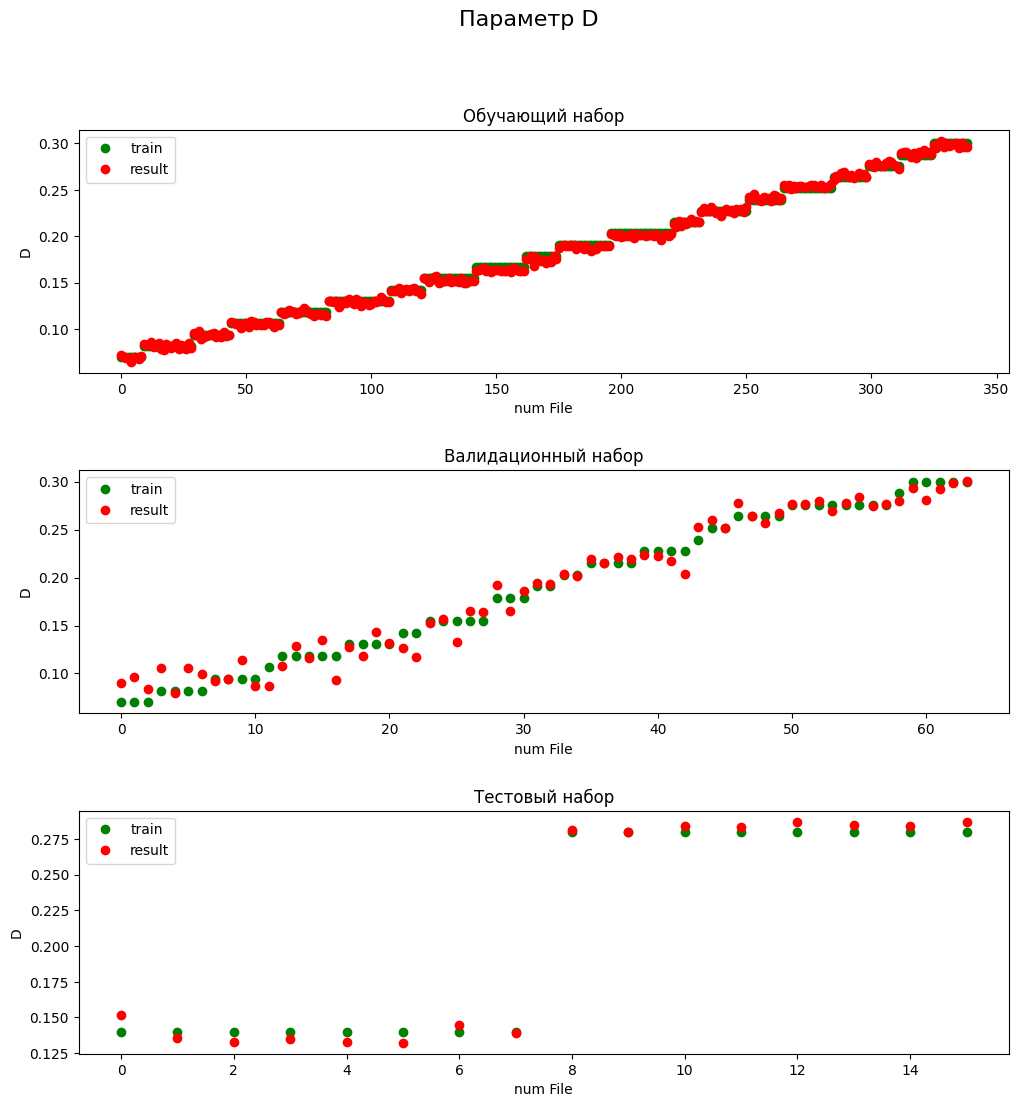

In [15]:
for param_index, param in enumerate(params):
    show(param_index, param)

In [16]:
def get_loss(result, real, i):
    error_m = torch.nn.MSELoss()(result[:, i], real[:, i]).item()
    error_a = torch.nn.L1Loss()(result[:, i], real[:, i]).item()
    return round(error_m, 6), round(error_a, 6)

def print_errors(i):
    train_error_m, train_error_a = get_loss(y_train_result, y_train, i)
    print('train error L1', train_error_a, 'MSE', train_error_m)
    val_error_m, val_error_a = get_loss(y_test_result, y_test, i)
    print('val error L1', val_error_a, 'MSE', val_error_m)
    test_error_m, test_error_a = get_loss(y_val_result, y_val, i)
    print('test error L1', test_error_a, 'MSE', test_error_m)

In [17]:
for param_index, param in enumerate(params):
    print(param, 'errors')
    print_errors(param_index)

D errors
train error L1 0.033551 MSE 0.001692
val error L1 0.074383 MSE 0.007245
test error L1 0.132447 MSE 0.030874


In [18]:
phases = read_phase_file('test_phases')
phases = torch.tensor(phases, dtype=torch.float, device=device)
phases = phases.unsqueeze(0)
print(phases.size())
print(x_train.size())

FileNotFoundError: [Errno 2] No such file or directory: 'test_phases'

In [ ]:
result = best_model.forward(phases).detach().cpu().numpy()
result = list(denorm(result, mean, dispersion)[0])
for r, p in zip(result, params):
    print(p, round(r, 4))